In [3]:
# Load packages
library('ggplot2') # visualization
library('ggthemes') # visualization
library('scales') # visualization
library('knitr') # visualization
library('dplyr') # data manipulation
library('mice') # imputation
library('randomForest') # classification algorithm

In [4]:
# import our two data sets
train <- read.csv('./input/train.csv', na = '')
test <- read.csv('./input/test.csv', na = '')

full <- bind_rows(train, test) # combine them so we can perform operations on both.

# The Data
Let's just go column by column and see what relevant data they provide and if there's any opportunity for some **feature engineering**.

## PassengerId
Nothing useful here. Moving on.

## Pclass
This will surely yield some useful information, let's see.

In [5]:
table(full$Survived, full$Pclass)

   
      1   2   3
  0  80  97 372
  1 136  87 119

Clearly, being rich helped. It makes sense, since the first class passengers had access to the upper decks and had a better chance of being close to lifeboats when the boat started to sink. The data is pretty straightforward and there's not much additional data to be gleaned (yet).

## Name
The names of the passengers has some value, I think. In particular, the titles given to each passenger, especially the designation of 'Miss' and 'Mrs' to differentiate married and unwed women, could produce additional data for our algorithm.

In [6]:
# Grab passenger titles
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)
full %>% group_by(Sex) %>% count(Title)

Sex,Title,n
<chr>,<chr>,<int>
female,Dona,1
female,Dr,1
female,Lady,1
female,Miss,260
female,Mlle,2
female,Mme,1
female,Mrs,197
female,Ms,2
female,the Countess,1


In [7]:
# Let's condense these a bit. The titles below are too uncommon to really help, I think.
misc <- c('Dona', 'Dr', 'Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Major', 'Rev', 'Sir')
full$Title[full$Title %in% misc] <- 'Misc'

# 'Mlle' and 'Ms' can be renamed to the more prevalent 'Miss' title. Same for 'Mme' and 'Mrs'.
full$Title[full$Title == 'Mlle'] <- 'Miss' 
full$Title[full$Title == 'Ms'] <- 'Miss'
full$Title[full$Title == 'Mme'] <- 'Mrs'

full %>% group_by(Survived) %>% count(Title)

Survived,Title,n
<int>,<chr>,<int>
0,Master,17
0,Misc,15
0,Miss,55
0,Mr,436
0,Mrs,26
1,Master,23
1,Misc,8
1,Miss,130
1,Mr,81


That may come in handy in the future. We can see a clear, positive survival rate for women, regardless of marital status. Interestingly, while 'Misters' seem to die at a very high rate, 'Masters' came out ahead, slightly. I'm unsure if that is anything but pure coincidence, but it's interesting, nonetheless.

**TODO:** Pulling out surnames to group families together could provide an additional useful data point; however, I have noted that some passengers boarded with both their married family as well as their family by birth. Also, in at least one case, I noted a married woman, Mrs. Johan Ahlin née Johanna Persdotter Larsson, who boarded with her brother, Mr. Johan Emil Petterson, and, as you can see, neither her married nor her maiden name was the same as her brothers, making linking them programmatically beyond my abilities. Still, I may try this again with surnames included.

## Sex
From the data we derived from passenger names, it looks like women had a higher survival rate. But let's double-check.

In [8]:
# lets see if we see any obvious death/survival correlations with the data at hand.
table(full$Survived, full$Sex)

   
    female male
  0     81  468
  1    233  109

That's pretty straightforward data, there. Let's move on to the next column, which I also predict will be a key factor.

## Age
We will actually skip this one for now, since I know there are missing values in this column, and I'd like to deal with them all at once.

## Family (SibSp & Parch)
There's definitely some data we can pull from here. Are families or single passengers more likely to survive? Does family size matter?

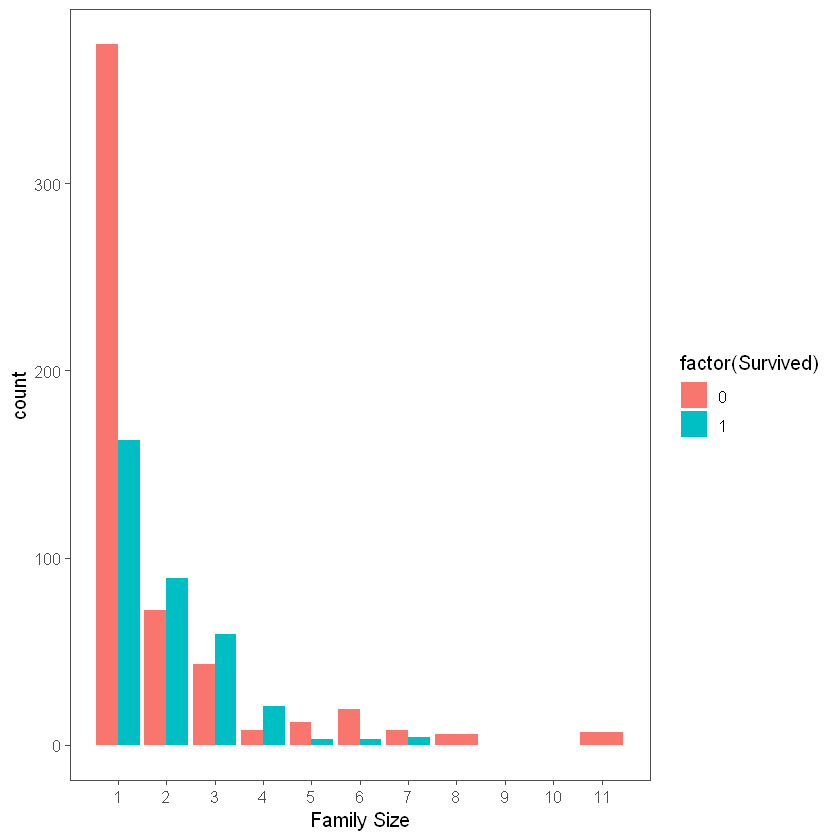

In [9]:
# First, let's create a family variable
full$FamSize <- full$SibSp + full$Parch + 1

# Let's get fancy with graphs
ggplot(full[1:891,], aes(x = FamSize, fill = factor(Survived))) +
    geom_bar(stat = 'count', position = 'dodge') +
    scale_x_continuous(breaks = c(min(full$FamSize):max(full$FamSize))) +
    labs(x = 'Family Size') +
    theme_few()

Small families seemed to fair reasonably well, while single people (whom we've already seen are mostly male and therefore more likely to have perished) and very large families did worse.

## Ticket
Hmmm, not sure what could be done with this. Perhaps some outside research would yield hidden information buried in these ticket numbers, but I don't see anything obviously useful.

## Fare
We already know that Passenger class played a role in survival, so I'm unsure what additional data this will yield. I'll keep it in mind, maybe it will prove useful.

## Cabin
We know the Titanic struck the iceburg at 11:40pm, so there's a good chance that a number of passengers were in their rooms when the ship began to sink, so what deck they were on probably had some influence on survival. Looking at the data, it's obvious that a lot of data regarding where passengers were staying was lost in the crash and White Star apparently didn't log this information anywhere but the ship. We do know, though, how much passengers paid and what class they were in, so perhaps we can make an estimation on what floor each passenger was likely to stay on. We could probably also assign a cabin number if we pulled some data from Titanic blueprints, but let's hold off on that for now.

In [10]:
# Create a Deck variable. Get passenger decks A - G (plus the one guy known to be staying on Deck T, aka the Boat Deck):
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

## Embarked
And now we reach the last of our given data, port of embarkation. This may be useful in filling in some other missing fields, but unless the majority of the passengers embarking out of, say, Queensland, just so happened to be remarkable swimmers with an impressive resistance to freezing waters, I don't believe it will have a direct correlation to survival.

In [11]:
# Out of curiosity, though, let's look at a few things.
table(full$Embarked, full$Pclass)
table(full$Embarked, full$Sex)
table(full$Embarked, full$Survived)

   
      1   2   3
  C 141  28 101
  Q   3   7 113
  S 177 242 495

   
    female male
  C    113  157
  Q     60   63
  S    291  623

   
      0   1
  C  75  93
  Q  47  30
  S 427 217

# Imputation
We've got missing values, let's fill those in.

Lots of 3rd class men came out of Southampton, perhaps laborers and the like looking to migrate to America?

In [12]:
# What values are missing?
sapply(full, function(x) sum(is.na(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1        1014           2 
      Title     FamSize        Deck 
          0           0        1014

In [13]:
# We want each column to have at most 5% missing values, so lets see which columns will need work.   
pMiss <- function(x){sum(is.na(x))/length(x)*100}
apply(full,2,pMiss)

PassengerId    Survived      Pclass        Name         Sex         Age 
 0.00000000 31.93277311  0.00000000  0.00000000  0.00000000 20.09167303 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
 0.00000000  0.00000000  0.00000000  0.07639419 77.46371276  0.15278839 
      Title     FamSize        Deck 
 0.00000000  0.00000000 77.46371276

Fare and Embarked are simple, we can probably do those ourselves. Age and Deck are missing quite a few more values, so we'll rely on MICE (Multivariate Imputation by Chained Equations) to calculate missing values.

In [14]:
# Let's do the easy ones first.
which(is.na(full$Fare), arr.ind=TRUE)

[1] 1044

In [15]:
str(full[1044, c('Pclass','Embarked')])
x <- subset(full, Pclass == 3 & Embarked == 'S' & Fare)

x %>% count(Fare) %>% arrange(-n)

'data.frame':	1 obs. of  2 variables:
 $ Pclass  : int 3
 $ Embarked: chr "S"


Fare,n
<dbl>,<int>
8.0500,60
7.8958,43
7.7750,26
7.9250,23
7.8542,21
8.6625,20
7.2500,17
9.5000,12
16.1000,12


In [16]:
full$Fare[1044] = 8.05

In [17]:
which(is.na(full$Embarked), arr.ind=TRUE)

[1]  62 830

In [18]:
str(full[c(62, 830), c('Pclass', 'Fare')])

'data.frame':	2 obs. of  2 variables:
 $ Pclass: int  1 1
 $ Fare  : num  80 80


In [19]:
C <- full[full$Embarked == 'C' & full$Pclass == 1,]$Fare
Q <- full[full$Embarked == 'Q' & full$Pclass == 1,]$Fare
S <- full[full$Embarked == 'S' & full$Pclass == 1,]$Fare

cat(paste('Median first class ticket price from Cherbourg was $',format(round(median(C, na.rm = TRUE), 2), nsmall = 2),', $',
          format(round(median(Q, na.rm = TRUE), 2), nsmall = 2),' for Queenstown, and $', format(round(median(S, na.rm = TRUE), 2), nsmall = 2),
' for Southampton.'))

Median first class ticket price from Cherbourg was $ 76.73 , $ 90.00  for Queenstown, and $ 52.00  for Southampton.

Median fare for a first class passenger out of Cherbourg was close enough to the fare paid by our two passengers that I feel confident assigning it as their port.

In [20]:
full$Embarked[c(62, 830)] <- 'C'

In [21]:
# Now for a big one, and one I don't feel confident trying by hand: age. I'm using mice because it appears to be the gold-standard.
# Turn our variables into factors
factor_vars <- c('Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'Embarked')
full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))

# Set our random seed
set.seed(04141912)

# Do the thing
micify_pmm <- mice(full[, !names(full) %in% c('PassengerId','Name','Ticket','Cabin','Family','Surname','Survived')], method = 'pmm', printFlag=FALSE)
micify_rf <- mice(full[, !names(full) %in% c('PassengerId','Name','Ticket','Cabin','Family','Surname','Survived')], method = 'rf', printFlag=FALSE)

Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"


In [22]:
mice_output_pmm <- complete(micify_pmm)
mice_output_rf <- complete(micify_rf)

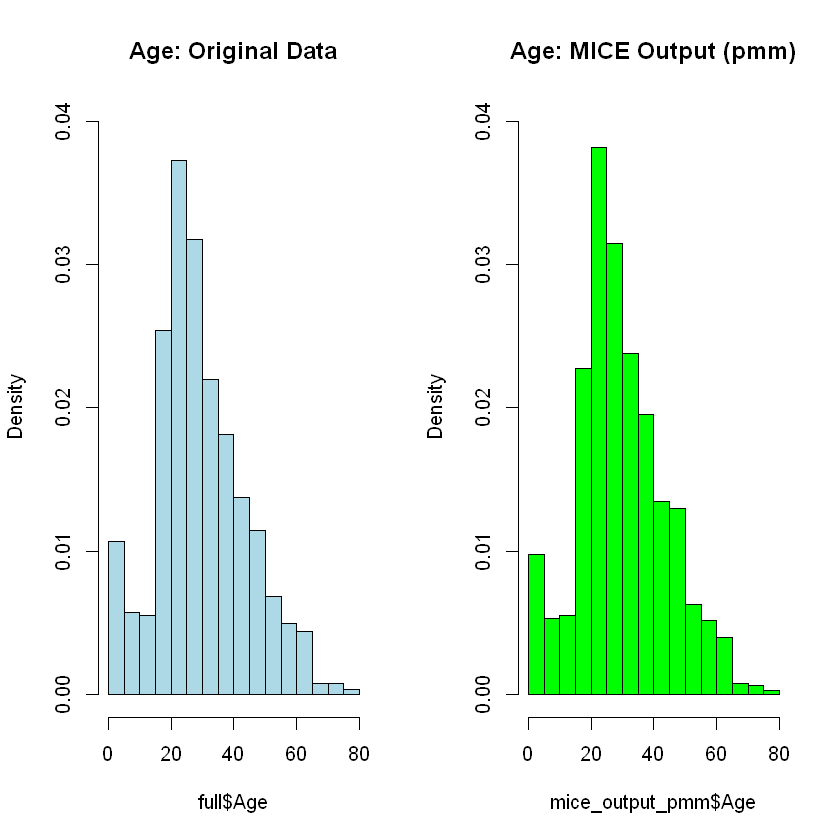

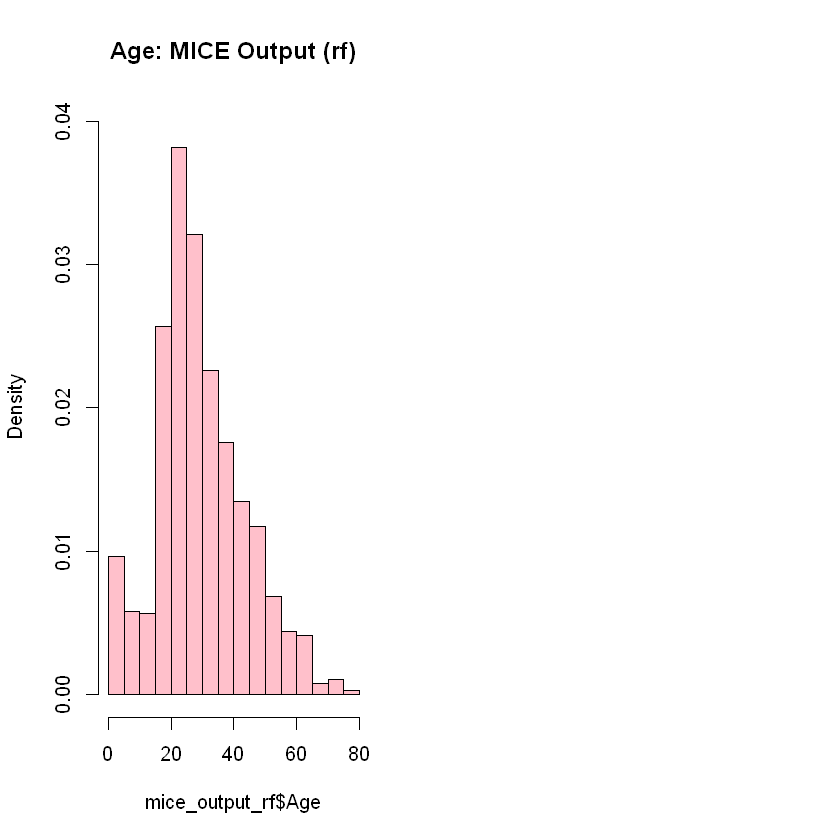

In [23]:
# Plot age distributions
par(mfrow=c(1,2))
hist(full$Age, freq=F, main='Age: Original Data', 
  col='lightblue', ylim=c(0,0.04))
hist(mice_output_pmm$Age, freq=F, main='Age: MICE Output (pmm)', 
  col='green', ylim=c(0,0.04))
hist(mice_output_rf$Age, freq=F, main='Age: MICE Output (rf)', 
  col='pink', ylim=c(0,0.04))

In [24]:
# The random forest imputations seems to give us data closest to the density present in the known data, so we'll go with that one.
full$Age <- mice_output_rf$Age

# Prediction

There are definitely more things we could do as far as feature engineering, but I'm going to stop here as a first pass.

In [25]:
# Split the data back into a train set and a test set
train <- full[1:891,]
test <- full[892:1309,]

In [26]:
set.seed(1500705)

rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age + Fare + 
                                            Embarked + Title + FamSize,
                                            data = train)

In [27]:
# Predict using the test set
prediction <- predict(rf_model, test)

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution <- data.frame(PassengerID = test$PassengerId, Survived = prediction)

# Write the solution to file
write.csv(solution, file = 'output/Solution.csv', row.names = F)